In [5]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from matplotlib.pyplot import specgram
import math
from random import shuffle

TODO:

HDF5
RCNN

In [6]:
#hop 10ms, window 40
def appendSounds(data,labels,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=506,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64),ref_power= np.max)
    iterator = 0
    while iterator+16<=mel.shape[1]:
        data.append(mel[:,iterator:iterator+16].flatten())
        labels.append(classNumber)
        iterator+=16

In [7]:
#hop 10ms, window 40
def appendTracks(data,labels,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=506,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64),ref_power= np.max)
    data.append(mel)
    labels.append(classNumber)

In [50]:
from multiprocessing import Process, Lock, Pipe,Event
import time
from keras import utils


allData,allLabels=[],[]
trainData,trainLabels= [],[]
tuneData,tuneLabels=[],[]
testData,testLabels=[],[]
#function to extract data using multiprocessing
def add(x,c):
    tempdata,templabels = [],[]
    if int(x[4])<9:
        try:
            int(x[5])
        except:
            #split for training set - loses information about which clip batch comes from 
            for file in glob.glob(x):
                appendSounds(tempdata, templabels, file)
        else:
            #split for testing set - presumes batches of sound within clip
            for file in glob.glob(x):
                appendTracks(tempdata, templabels, file)
        
        
    else:
        #split for testing set - presumes batches of sound within clip
        for file in glob.glob(x):
            appendTracks(tempdata, templabels, file)
            
    c.send(zip(tempdata, templabels))
    del tempdata,templabels
        
ts = time.time()

#doing actual multiprocessing extraction
if __name__ == '__main__':
    threads= []
    connections=[0]*10
    lock = Lock()
    for x in xrange(1,11):
        connections[x-1], childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    fold = 1
    for x,y in zip(threads,connections):
        tD, tL = zip(*y.recv())
        if fold <= 6:
            trainData += tD
            trainLabels += tL
        elif fold <= 8 :
            tuneData += tD
            tuneLabels += tL
        else:
            testData += tD
            testLabels += tL
        fold+=1
        
    #save data into numpy array, change classes label using onehot encoding
    trainData, trainLabels = np.array(trainData), np.array(utils.to_categorical(trainLabels, num_classes=10))
    tuneData, tuneLabels = np.array(tuneData), np.array(utils.to_categorical(tuneLabels, num_classes=10))
    #testData, testLabels = np.array(testData), np.array(utils.to_categorical(testLabels, num_classes=10))
    
    print "I'm done, time was:" , time.time()-ts

ValueError: could not broadcast input array from shape (64,80) into shape (64)

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import regularizers
from random import uniform
from math import pow
rates2 = []

#standard NN - was fine tuned for another example, outdated right now

LR,L2= 0.008,0.00207
net = Sequential()
net.add(Dense(512, activation='relu', input_dim=1024,
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.5))
net.add(Dense(256, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.3))
net.add(Dense(64, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.1))
net.add(Dense(10, activation='softmax'))
net.compile(loss='categorical_crossentropy',
           optimizer = SGD(lr=LR,decay=1e-6, momentum=0.9,nesterov=True),
           metrics = ['accuracy'])

net.fit(trainData, trainLabels, epochs = 100, batch_size=128, verbose=0)
rates2.append([net.evaluate(tuneData,tuneLabels, batch_size=16384)[1],
             net.evaluate(trainData,trainLabels, batch_size=16384)[1],
             LR,L2])
print ("Tune score: %.3f Train score: %.3f Learning rate: %f L2 reg: %f" %(rates2[-1][0],rates2[-1][1],LR, L2))

23987/23987 [==============================] - 0s     
Tune score: 0.294 Train score: 0.351 Learning rate: 0.008000 L2 reg: 0.002070


In [54]:
#reshape training and tune set so it fits CNN

trainData=np.reshape(trainData,(trainData.shape[0],64,16))
tuneData=np.reshape(tuneData,(tuneData.shape[0],64,16))
trainData=np.expand_dims(trainData,axis=3)
tuneData=np.expand_dims(tuneData,axis=3)
testLabels = np.array(utils.to_categorical(testLabels, num_classes=10))
print trainData.shape, tuneData.shape

(23987, 64, 16, 1) (7322, 64, 16, 1)


In [58]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from keras.optimizers import SGD

#CNN working on batches of image, accuracy up to 72%

model = Sequential()
model.add(ZeroPadding2D(padding = (1,1), input_shape=(64, 16, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

model.fit(np.concatenate((trainData,tuneData),axis=0), np.concatenate((trainLabels,tuneLabels),axis=0),
          batch_size=512, epochs=1800,verbose=2)

Epoch 1/1800
4s - loss: 1.6324 - acc: 0.4370
Epoch 2/1800
3s - loss: 1.1142 - acc: 0.6213
Epoch 3/1800
3s - loss: 0.8955 - acc: 0.7014
Epoch 4/1800
3s - loss: 0.7699 - acc: 0.7475
Epoch 5/1800
3s - loss: 0.6529 - acc: 0.7858
Epoch 6/1800
3s - loss: 0.5892 - acc: 0.8076
Epoch 7/1800
3s - loss: 0.5208 - acc: 0.8305
Epoch 8/1800
3s - loss: 0.4769 - acc: 0.8425
Epoch 9/1800
3s - loss: 0.4371 - acc: 0.8578
Epoch 10/1800
3s - loss: 0.4129 - acc: 0.8639
Epoch 11/1800
3s - loss: 0.3752 - acc: 0.8750
Epoch 12/1800
3s - loss: 0.3580 - acc: 0.8808
Epoch 13/1800
3s - loss: 0.3355 - acc: 0.8879
Epoch 14/1800
3s - loss: 0.3198 - acc: 0.8942
Epoch 15/1800
3s - loss: 0.3063 - acc: 0.8980
Epoch 16/1800
3s - loss: 0.2905 - acc: 0.9045
Epoch 17/1800
3s - loss: 0.2728 - acc: 0.9083
Epoch 18/1800
3s - loss: 0.2560 - acc: 0.9134
Epoch 19/1800
3s - loss: 0.2452 - acc: 0.9190
Epoch 20/1800
3s - loss: 0.2419 - acc: 0.9183
Epoch 21/1800
3s - loss: 0.2285 - acc: 0.9212
Epoch 22/1800
3s - loss: 0.2161 - acc: 0.92

4s - loss: 0.0262 - acc: 0.9905
Epoch 179/1800
4s - loss: 0.0233 - acc: 0.9921
Epoch 180/1800
4s - loss: 0.0253 - acc: 0.9905
Epoch 181/1800
4s - loss: 0.0258 - acc: 0.9903
Epoch 182/1800
4s - loss: 0.0259 - acc: 0.9909
Epoch 183/1800
4s - loss: 0.0227 - acc: 0.9919
Epoch 184/1800
4s - loss: 0.0250 - acc: 0.9913
Epoch 185/1800
3s - loss: 0.0239 - acc: 0.9918
Epoch 186/1800
3s - loss: 0.0309 - acc: 0.9886
Epoch 187/1800
4s - loss: 0.0260 - acc: 0.9910
Epoch 188/1800
4s - loss: 0.0222 - acc: 0.9919
Epoch 189/1800
3s - loss: 0.0269 - acc: 0.9902
Epoch 190/1800
4s - loss: 0.0255 - acc: 0.9908
Epoch 191/1800
3s - loss: 0.0233 - acc: 0.9916
Epoch 192/1800
4s - loss: 0.0247 - acc: 0.9909
Epoch 193/1800
4s - loss: 0.0244 - acc: 0.9913
Epoch 194/1800
4s - loss: 0.0248 - acc: 0.9912
Epoch 195/1800
3s - loss: 0.0258 - acc: 0.9905
Epoch 196/1800
3s - loss: 0.0301 - acc: 0.9883
Epoch 197/1800
3s - loss: 0.0252 - acc: 0.9911
Epoch 198/1800
4s - loss: 0.0237 - acc: 0.9917
Epoch 199/1800
4s - loss: 0.

3s - loss: 0.0137 - acc: 0.9946
Epoch 354/1800
3s - loss: 0.0136 - acc: 0.9946
Epoch 355/1800
3s - loss: 0.0143 - acc: 0.9946
Epoch 356/1800
3s - loss: 0.0137 - acc: 0.9948
Epoch 357/1800
3s - loss: 0.0140 - acc: 0.9948
Epoch 358/1800
3s - loss: 0.0145 - acc: 0.9947
Epoch 359/1800
3s - loss: 0.0137 - acc: 0.9946
Epoch 360/1800
3s - loss: 0.0144 - acc: 0.9947
Epoch 361/1800
3s - loss: 0.0151 - acc: 0.9944
Epoch 362/1800
3s - loss: 0.0162 - acc: 0.9939
Epoch 363/1800
3s - loss: 0.0144 - acc: 0.9947
Epoch 364/1800
3s - loss: 0.0137 - acc: 0.9950
Epoch 365/1800
3s - loss: 0.0129 - acc: 0.9952
Epoch 366/1800
3s - loss: 0.0143 - acc: 0.9948
Epoch 367/1800
3s - loss: 0.0129 - acc: 0.9956
Epoch 368/1800
3s - loss: 0.0144 - acc: 0.9946
Epoch 369/1800
3s - loss: 0.0138 - acc: 0.9950
Epoch 370/1800
3s - loss: 0.0141 - acc: 0.9946
Epoch 371/1800
3s - loss: 0.0133 - acc: 0.9954
Epoch 372/1800
3s - loss: 0.0134 - acc: 0.9956
Epoch 373/1800
3s - loss: 0.0149 - acc: 0.9951
Epoch 374/1800
3s - loss: 0.

3s - loss: 0.0117 - acc: 0.9955
Epoch 529/1800
3s - loss: 0.0115 - acc: 0.9964
Epoch 530/1800
3s - loss: 0.0098 - acc: 0.9962
Epoch 531/1800
3s - loss: 0.0106 - acc: 0.9962
Epoch 532/1800
3s - loss: 0.0102 - acc: 0.9964
Epoch 533/1800
3s - loss: 0.0113 - acc: 0.9957
Epoch 534/1800
3s - loss: 0.0103 - acc: 0.9962
Epoch 535/1800
3s - loss: 0.0101 - acc: 0.9963
Epoch 536/1800
3s - loss: 0.0098 - acc: 0.9961
Epoch 537/1800
3s - loss: 0.0094 - acc: 0.9964
Epoch 538/1800
3s - loss: 0.0102 - acc: 0.9962
Epoch 539/1800
3s - loss: 0.0108 - acc: 0.9959
Epoch 540/1800
3s - loss: 0.0105 - acc: 0.9960
Epoch 541/1800
3s - loss: 0.0134 - acc: 0.9953
Epoch 542/1800
3s - loss: 0.0122 - acc: 0.9955
Epoch 543/1800
3s - loss: 0.0099 - acc: 0.9966
Epoch 544/1800
3s - loss: 0.0108 - acc: 0.9959
Epoch 545/1800
3s - loss: 0.0106 - acc: 0.9959
Epoch 546/1800
3s - loss: 0.0118 - acc: 0.9952
Epoch 547/1800
3s - loss: 0.0113 - acc: 0.9959
Epoch 548/1800
3s - loss: 0.0111 - acc: 0.9958
Epoch 549/1800
3s - loss: 0.

3s - loss: 0.0084 - acc: 0.9970
Epoch 704/1800
3s - loss: 0.0092 - acc: 0.9962
Epoch 705/1800
3s - loss: 0.0089 - acc: 0.9967
Epoch 706/1800
3s - loss: 0.0082 - acc: 0.9970
Epoch 707/1800
3s - loss: 0.0081 - acc: 0.9969
Epoch 708/1800
3s - loss: 0.0086 - acc: 0.9966
Epoch 709/1800
3s - loss: 0.0085 - acc: 0.9966
Epoch 710/1800
3s - loss: 0.0090 - acc: 0.9968
Epoch 711/1800
3s - loss: 0.0077 - acc: 0.9975
Epoch 712/1800
3s - loss: 0.0081 - acc: 0.9966
Epoch 713/1800
3s - loss: 0.0087 - acc: 0.9966
Epoch 714/1800
3s - loss: 0.0106 - acc: 0.9965
Epoch 715/1800
3s - loss: 0.0101 - acc: 0.9961
Epoch 716/1800
3s - loss: 0.0087 - acc: 0.9966
Epoch 717/1800
3s - loss: 0.0090 - acc: 0.9966
Epoch 718/1800
3s - loss: 0.0077 - acc: 0.9972
Epoch 719/1800
3s - loss: 0.0097 - acc: 0.9962
Epoch 720/1800
3s - loss: 0.0084 - acc: 0.9969
Epoch 721/1800
3s - loss: 0.0092 - acc: 0.9966
Epoch 722/1800
3s - loss: 0.0079 - acc: 0.9968
Epoch 723/1800
3s - loss: 0.0089 - acc: 0.9966
Epoch 724/1800
3s - loss: 0.

3s - loss: 0.0073 - acc: 0.9968
Epoch 879/1800
3s - loss: 0.0073 - acc: 0.9970
Epoch 880/1800
3s - loss: 0.0071 - acc: 0.9970
Epoch 881/1800
3s - loss: 0.0075 - acc: 0.9974
Epoch 882/1800
3s - loss: 0.0074 - acc: 0.9971
Epoch 883/1800
3s - loss: 0.0083 - acc: 0.9969
Epoch 884/1800
3s - loss: 0.0099 - acc: 0.9968
Epoch 885/1800
3s - loss: 0.0079 - acc: 0.9971
Epoch 886/1800
3s - loss: 0.0081 - acc: 0.9968
Epoch 887/1800
3s - loss: 0.0072 - acc: 0.9972
Epoch 888/1800
3s - loss: 0.0084 - acc: 0.9967
Epoch 889/1800
3s - loss: 0.0083 - acc: 0.9970
Epoch 890/1800
3s - loss: 0.0077 - acc: 0.9969
Epoch 891/1800
3s - loss: 0.0074 - acc: 0.9971
Epoch 892/1800
3s - loss: 0.0075 - acc: 0.9974
Epoch 893/1800
3s - loss: 0.0079 - acc: 0.9969
Epoch 894/1800
3s - loss: 0.0084 - acc: 0.9971
Epoch 895/1800
3s - loss: 0.0070 - acc: 0.9974
Epoch 896/1800
3s - loss: 0.0066 - acc: 0.9973
Epoch 897/1800
3s - loss: 0.0070 - acc: 0.9975
Epoch 898/1800
3s - loss: 0.0082 - acc: 0.9970
Epoch 899/1800
3s - loss: 0.

3s - loss: 0.0067 - acc: 0.9973
Epoch 1053/1800
3s - loss: 0.0058 - acc: 0.9974
Epoch 1054/1800
3s - loss: 0.0067 - acc: 0.9973
Epoch 1055/1800
3s - loss: 0.0065 - acc: 0.9976
Epoch 1056/1800
3s - loss: 0.0064 - acc: 0.9976
Epoch 1057/1800
3s - loss: 0.0059 - acc: 0.9975
Epoch 1058/1800
4s - loss: 0.0074 - acc: 0.9971
Epoch 1059/1800
4s - loss: 0.0063 - acc: 0.9975
Epoch 1060/1800
4s - loss: 0.0065 - acc: 0.9973
Epoch 1061/1800
4s - loss: 0.0065 - acc: 0.9979
Epoch 1062/1800
3s - loss: 0.0061 - acc: 0.9977
Epoch 1063/1800
4s - loss: 0.0074 - acc: 0.9973
Epoch 1064/1800
4s - loss: 0.0075 - acc: 0.9971
Epoch 1065/1800
4s - loss: 0.0063 - acc: 0.9975
Epoch 1066/1800
4s - loss: 0.0070 - acc: 0.9971
Epoch 1067/1800
4s - loss: 0.0076 - acc: 0.9971
Epoch 1068/1800
3s - loss: 0.0071 - acc: 0.9970
Epoch 1069/1800
3s - loss: 0.0054 - acc: 0.9980
Epoch 1070/1800
3s - loss: 0.0066 - acc: 0.9975
Epoch 1071/1800
3s - loss: 0.0072 - acc: 0.9972
Epoch 1072/1800
3s - loss: 0.0060 - acc: 0.9973
Epoch 10

3s - loss: 0.0057 - acc: 0.9977
Epoch 1224/1800
3s - loss: 0.0063 - acc: 0.9974
Epoch 1225/1800
3s - loss: 0.0090 - acc: 0.9967
Epoch 1226/1800
3s - loss: 0.0084 - acc: 0.9967
Epoch 1227/1800
3s - loss: 0.0054 - acc: 0.9981
Epoch 1228/1800
3s - loss: 0.0066 - acc: 0.9974
Epoch 1229/1800
3s - loss: 0.0064 - acc: 0.9975
Epoch 1230/1800
3s - loss: 0.0057 - acc: 0.9976
Epoch 1231/1800
3s - loss: 0.0068 - acc: 0.9974
Epoch 1232/1800
3s - loss: 0.0068 - acc: 0.9973
Epoch 1233/1800
3s - loss: 0.0065 - acc: 0.9975
Epoch 1234/1800
3s - loss: 0.0058 - acc: 0.9976
Epoch 1235/1800
3s - loss: 0.0061 - acc: 0.9975
Epoch 1236/1800
3s - loss: 0.0065 - acc: 0.9972
Epoch 1237/1800
3s - loss: 0.0065 - acc: 0.9972
Epoch 1238/1800
3s - loss: 0.0062 - acc: 0.9977
Epoch 1239/1800
3s - loss: 0.0065 - acc: 0.9972
Epoch 1240/1800
3s - loss: 0.0051 - acc: 0.9980
Epoch 1241/1800
3s - loss: 0.0070 - acc: 0.9971
Epoch 1242/1800
3s - loss: 0.0068 - acc: 0.9973
Epoch 1243/1800
3s - loss: 0.0058 - acc: 0.9979
Epoch 12

3s - loss: 0.0060 - acc: 0.9975
Epoch 1395/1800
3s - loss: 0.0048 - acc: 0.9981
Epoch 1396/1800
3s - loss: 0.0057 - acc: 0.9975
Epoch 1397/1800
3s - loss: 0.0056 - acc: 0.9978
Epoch 1398/1800
3s - loss: 0.0058 - acc: 0.9976
Epoch 1399/1800
3s - loss: 0.0053 - acc: 0.9978
Epoch 1400/1800
3s - loss: 0.0061 - acc: 0.9979
Epoch 1401/1800
3s - loss: 0.0061 - acc: 0.9976
Epoch 1402/1800
3s - loss: 0.0051 - acc: 0.9977
Epoch 1403/1800
3s - loss: 0.0063 - acc: 0.9975
Epoch 1404/1800
3s - loss: 0.0049 - acc: 0.9979
Epoch 1405/1800
3s - loss: 0.0048 - acc: 0.9980
Epoch 1406/1800
3s - loss: 0.0053 - acc: 0.9979
Epoch 1407/1800
3s - loss: 0.0055 - acc: 0.9979
Epoch 1408/1800
3s - loss: 0.0053 - acc: 0.9981
Epoch 1409/1800
3s - loss: 0.0058 - acc: 0.9981
Epoch 1410/1800
3s - loss: 0.0049 - acc: 0.9979
Epoch 1411/1800
3s - loss: 0.0046 - acc: 0.9981
Epoch 1412/1800
3s - loss: 0.0052 - acc: 0.9981
Epoch 1413/1800
3s - loss: 0.0048 - acc: 0.9980
Epoch 1414/1800
3s - loss: 0.0063 - acc: 0.9974
Epoch 14

4s - loss: 0.0046 - acc: 0.9981
Epoch 1566/1800
3s - loss: 0.0047 - acc: 0.9981
Epoch 1567/1800
4s - loss: 0.0048 - acc: 0.9980
Epoch 1568/1800
3s - loss: 0.0053 - acc: 0.9980
Epoch 1569/1800
3s - loss: 0.0050 - acc: 0.9980
Epoch 1570/1800
3s - loss: 0.0041 - acc: 0.9984
Epoch 1571/1800
3s - loss: 0.0048 - acc: 0.9981
Epoch 1572/1800
3s - loss: 0.0049 - acc: 0.9979
Epoch 1573/1800
4s - loss: 0.0046 - acc: 0.9980
Epoch 1574/1800
4s - loss: 0.0051 - acc: 0.9981
Epoch 1575/1800
3s - loss: 0.0047 - acc: 0.9981
Epoch 1576/1800
3s - loss: 0.0043 - acc: 0.9985
Epoch 1577/1800
4s - loss: 0.0049 - acc: 0.9980
Epoch 1578/1800
4s - loss: 0.0046 - acc: 0.9982
Epoch 1579/1800
3s - loss: 0.0050 - acc: 0.9982
Epoch 1580/1800
4s - loss: 0.0052 - acc: 0.9978
Epoch 1581/1800
3s - loss: 0.0046 - acc: 0.9982
Epoch 1582/1800
4s - loss: 0.0036 - acc: 0.9985
Epoch 1583/1800
4s - loss: 0.0053 - acc: 0.9978
Epoch 1584/1800
3s - loss: 0.0049 - acc: 0.9981
Epoch 1585/1800
4s - loss: 0.0054 - acc: 0.9976
Epoch 15

4s - loss: 0.0041 - acc: 0.9984
Epoch 1737/1800
4s - loss: 0.0048 - acc: 0.9981
Epoch 1738/1800
4s - loss: 0.0063 - acc: 0.9977
Epoch 1739/1800
3s - loss: 0.0060 - acc: 0.9978
Epoch 1740/1800
3s - loss: 0.0045 - acc: 0.9982
Epoch 1741/1800
4s - loss: 0.0049 - acc: 0.9982
Epoch 1742/1800
4s - loss: 0.0051 - acc: 0.9978
Epoch 1743/1800
4s - loss: 0.0044 - acc: 0.9985
Epoch 1744/1800
4s - loss: 0.0044 - acc: 0.9982
Epoch 1745/1800
4s - loss: 0.0044 - acc: 0.9981
Epoch 1746/1800
4s - loss: 0.0043 - acc: 0.9981
Epoch 1747/1800
3s - loss: 0.0048 - acc: 0.9977
Epoch 1748/1800
3s - loss: 0.0044 - acc: 0.9980
Epoch 1749/1800
3s - loss: 0.0039 - acc: 0.9984
Epoch 1750/1800
3s - loss: 0.0047 - acc: 0.9983
Epoch 1751/1800
3s - loss: 0.0043 - acc: 0.9984
Epoch 1752/1800
3s - loss: 0.0040 - acc: 0.9983
Epoch 1753/1800
3s - loss: 0.0039 - acc: 0.9984
Epoch 1754/1800
3s - loss: 0.0048 - acc: 0.9982
Epoch 1755/1800
3s - loss: 0.0052 - acc: 0.9981
Epoch 1756/1800
3s - loss: 0.0043 - acc: 0.9985
Epoch 17

In [59]:
#final scoring function. isnt used in training.
#CNN predicts classes for all parts of clip and sums probablities, chooses best
#scores is confusion matrix
scores = np.zeros((10,10))
missed = 0
for track,label in zip(testData,testLabels):
    tempD =[]
    iterator = 0
    if track.shape[1]<16:
        t = track.shape[1]
        b = np.zeros((64,16))
        b[:, :-16+t]= track
        tempD.append(b)
    while (iterator+16<=track.shape[1]):
        tempD.append(track[:,iterator:iterator+16])
        iterator+=16
    tempD= np.array(tempD)
    tempD = np.expand_dims(tempD, axis=3)
    predicted = model.predict(tempD, batch_size=1, verbose=2)
    scores[predicted.sum(axis=0).argmax(),label.argmax()]+=1

accuracy = scores.trace()/scores.sum()    
print accuracy

0.693284936479


In [57]:
from sklearn.preprocessing import normalize

#prints scores and graphic version
print scores
normscores =normalize(scores,norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()

[[  79.    1.    0.    5.    0.    9.    0.    5.    1.    0.]
 [   0.   47.    0.    0.    1.    0.    0.    0.    0.    0.]
 [  24.    1.  158.   32.    4.   17.    1.    3.   25.   15.]
 [   0.    2.   13.  147.    5.    0.   13.    0.    8.    1.]
 [  42.    4.    3.    4.  129.    0.    1.   55.    0.    1.]
 [   4.    0.    2.    1.    4.  135.    0.    1.    0.    0.]
 [   0.    0.    2.    1.    0.    0.   47.    0.    0.    0.]
 [  16.    6.    4.    3.   38.   13.    0.  114.    0.    0.]
 [  10.    1.    7.    2.    2.    0.    1.    0.  131.    1.]
 [  25.    3.   11.    5.   17.    8.    0.    0.    0.  182.]]


Some charts used in finetuning of previous NN

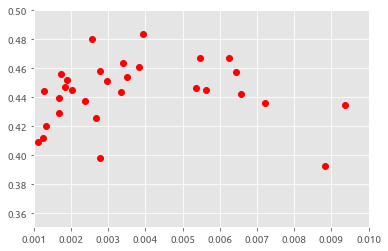

In [43]:
plt.plot(rates[:,2],rates[:,0],'ro')
plt.axis([0.001,0.01,0.35,0.5])
plt.show()
#128 batch - f(learning_Rate)=score

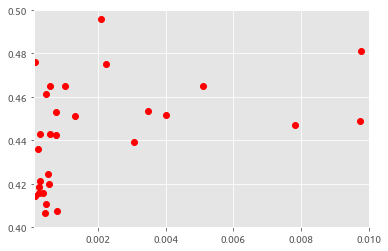

In [50]:
plt.plot(rates1[:,3],rates1[:,0],'ro')
plt.axis([0.0001,0.01,0.4,0.5])
plt.show()
#128 batch - f(L2 lambda)=score, lr=0.0038